In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import accuracy_score, recall_score, precision_score, \
f1_score, roc_curve, auc, roc_auc_score, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from collections import OrderedDict, Counter
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from sklearn.metrics import auc, roc_auc_score

sns.set(font_scale=1.4, style='white')

In [2]:
plt.style.use('seaborn-colorblind')

In [3]:
!ls result/

ls: result/: No such file or directory


In [3]:
with open('result/xgb_model.pkl', 'rb') as f:
    gbm = pickle.load(f)

In [4]:
with open('result/feature_names.pkl', 'rb') as f:
    feature_name = pickle.load(f)

In [15]:
importance = gbm.get_booster().get_score()

In [9]:
gain = gbm.get_booster().get_score(importance_type='gain')

In [39]:
f_import, fscore = zip(*sorted(importance.items(), key=lambda x:x[1], reverse=True))
x = range(len(f_import))

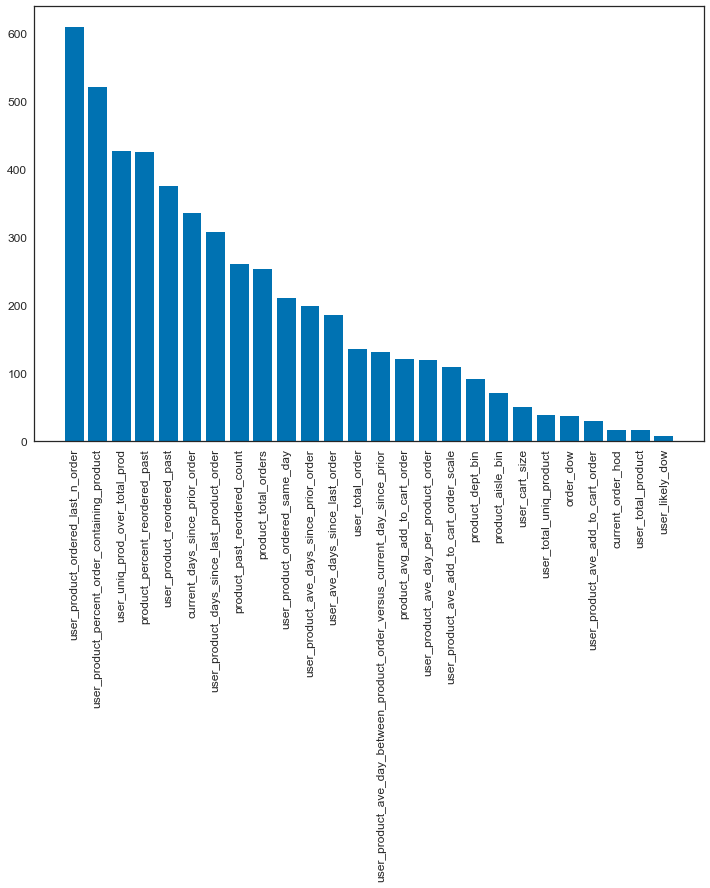

In [41]:
plt.figure(figsize=(12,8))
plt.bar(x, fscore)
plt.xticks(x,f_import, rotation=90);

In [43]:
f_gain, gscore = zip(*sorted(gain.items(), key=lambda x:x[1], reverse=True))
x = range(len(gain))

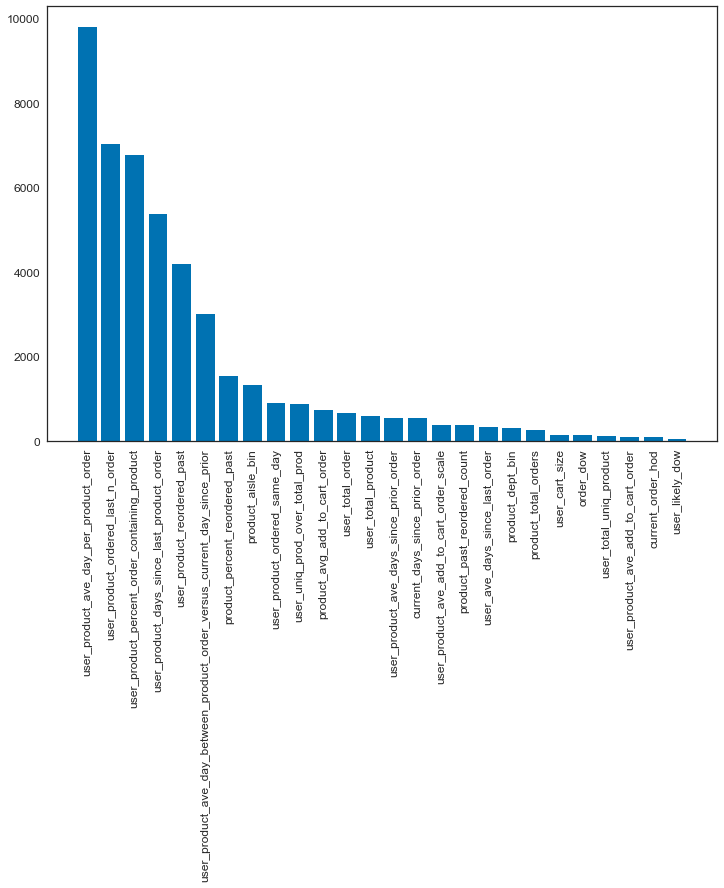

In [44]:
plt.figure(figsize=(12,8))
plt.bar(x, gscore)
plt.xticks(x,f_gain, rotation=90);

In [52]:
gain_df = pd.DataFrame({'feature_names': list(gain.keys()), 'gain':list(gain.values())})


In [78]:
#get feature type
def feature_type(x):
    if x.startswith('user_product'):
        return'User-Product'
    if x.startswith('user_'):
        return 'User'
    if x.startswith('product'):
        return 'Product'
    else:
        return 'Order'
    

In [79]:
gain_df['feature_type'] = gain_df['feature_names'].transform(feature_type)

In [80]:
gain_df

,feature_names,gain,feature_type
0,user_product_percent_order_containing_product,6762.366447,User-Product
1,user_product_ordered_last_n_order,7019.069401,User-Product
2,product_aisle_bin,1333.181074,Product
3,user_product_ave_day_per_product_order,9790.720947,User-Product
4,user_uniq_prod_over_total_prod,870.217928,User
5,product_percent_reordered_past,1551.883870,Product
6,user_product_ave_day_between_product_order_ver...,3011.673682,User-Product
7,user_product_ordered_same_day,910.902193,User-Product
8,user_product_reordered_past,4194.322334,User-Product
9,user_total_order,657.857221,User


In [81]:
gain_df.to_csv('feature_importance_gain.csv')

Use Tableau to generate bar plot for feature importance.

Check why the holdset f1 score is much lower than the cross validation on the subset

In [82]:
with open('result/y_pred_prob.pkl', 'rb') as f:
    y_pred_prob = pickle.load(f)

In [83]:
with open('result/0806_1pm_df_hod_test.pkl', 'rb') as f:
    df_hod_test = pickle.load(f)

In [84]:
y_true = df_hod_test['reordered']

In [85]:
fpr, tpr, t = roc_curve(y_true, y_pred_prob)

In [87]:
prec, rec, thr = precision_recall_curve(y_true, y_pred_prob)

In [92]:
thr.shape, prec.shape, rec.shape

((760826,), (760827,), (760827,))

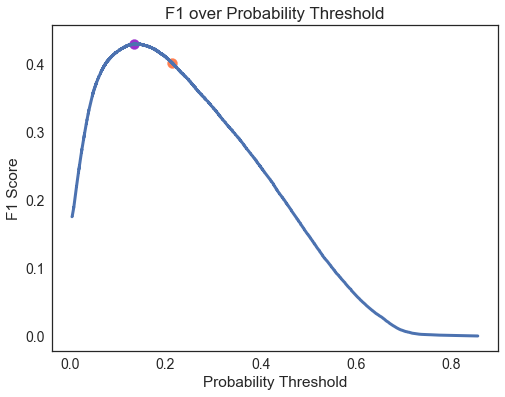

In [129]:
plt.figure(figsize=(8,6))
plt.plot(thr, (2*prec*rec/(prec+rec))[:-1], linewidth=3.0)
plt.scatter([0.13442038], [0.428], color='darkorchid', s=100)
plt.scatter([0.2138], [0.401], color='coral', s=100)
plt.xlabel('Probability Threshold')
plt.ylabel('F1 Score')
plt.title('F1 over Probability Threshold');

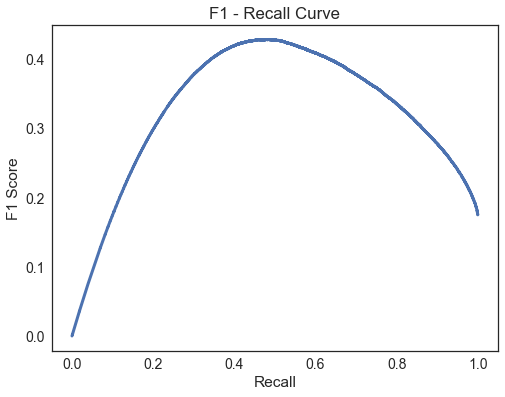

In [132]:
plt.figure(figsize=(8,6))
plt.plot(rec, 2*prec*rec/(prec+rec), linewidth=3.0)
plt.xlabel('Recall')
plt.ylabel('F1 Score')
plt.title('F1 - Recall Curve');

In [99]:
f1=0
r1=0
p1=0
t1=0
for r, p, t in zip(rec, prec, thr):
    if r and p:
        f=(2*r*p/(r+p))
        if f>f1:
            f1=f
            r1=r
            p1=p
            t1=t
print(f1, r1, p1, t1)

0.4284806695848317 0.4857090000924984 0.38331664789554915 0.13442038


EDA on sample of the traing set data

In [133]:
with open('result/0806_1pm_df_hod.pkl', 'rb') as f:
    df_train = pickle.load(f)

In [134]:
df_sub1 = df_train.sample(10000)

In [136]:
del df_train

In [143]:
df_sub1.to_csv('result/df_sub1.csv')

In [144]:
df_sub1.shape

(10000, 29)

In [3]:
#df_sub1 = pd.read_csv('result/df_sub1.csv')

In [4]:
df_sub1.head()

,Unnamed: 0,user_id,product_id,user_product_reordered_past,reordered,user_total_order,user_cart_size,user_total_product,user_ave_days_since_last_order,user_likely_dow,...,user_product_days_since_last_product_order,user_product_percent_order_containing_product,user_product_ave_day_per_product_order,order_dow,current_days_since_prior_order,user_product_ave_day_between_product_order_versus_current_day_since_prior,user_product_ordered_same_day,product_dept_bin,product_aisle_bin,current_order_hod
0,5266630,141084,35715,1,0.0,17,5.823529,99,13.250000,0.294118,...,36.0,0.117647,106.0,5,23.0,4.608696,0,-2,2,1
1,7244661,194136,41844,0,0.0,31,13.354839,414,11.200000,0.290323,...,158.0,0.032258,336.0,2,7.0,48.000000,0,-1,-1,-1
2,4279944,114273,2240,1,0.0,9,7.444444,67,21.500000,0.333333,...,71.0,0.222222,86.0,3,30.0,2.866667,0,-2,2,-1
3,3419209,91361,13629,0,1.0,24,13.791667,331,12.695652,0.666667,...,19.0,0.041667,292.0,6,7.0,41.714286,0,2,2,1
4,7577993,203256,18594,0,0.0,99,11.434343,1132,2.153061,0.616162,...,97.0,0.010101,211.0,5,4.0,52.750000,0,2,-1,-1


In [9]:
df_sub1.columns

Index(['Unnamed: 0', 'user_id', 'product_id', 'user_product_reordered_past',
       'reordered', 'user_total_order', 'user_cart_size', 'user_total_product',
       'user_ave_days_since_last_order', 'user_likely_dow',
       'user_total_uniq_product', 'user_uniq_prod_over_total_prod',
       'product_total_orders', 'product_avg_add_to_cart_order',
       'product_past_reordered_count', 'product_percent_reordered_past',
       'user_product_ave_add_to_cart_order',
       'user_product_ave_add_to_cart_order_scale',
       'user_product_ave_days_since_prior_order',
       'user_product_ordered_last_n_order',
       'user_product_days_since_last_product_order',
       'user_product_percent_order_containing_product',
       'user_product_ave_day_per_product_order', 'order_dow',
       'current_days_since_prior_order',
       'user_product_ave_day_between_product_order_versus_current_day_since_prior',
       'user_product_ordered_same_day', 'product_dept_bin',
       'product_aisle_bin', 'cur

In [69]:
product_info=pd.read_csv('data/products.csv')

In [70]:
df_p = pd.merge(df_sub1, product_info, on='product_id', how='left')

In [71]:
dept = pd.read_csv('data/departments.csv')

In [74]:
df_p=pd.merge(df_p, dept, on='department_id', how='left')

In [75]:
a = df_p.loc[df_p['reordered']==0,'department_id'].value_counts().sort_index()/\
df_p.loc[df_p['reordered']==0,'department_id'].count()
b = df_p.loc[df_p['reordered']==1,'department_id'].value_counts().sort_index()/\
df_p.loc[df_p['reordered']==1,'department_id'].count()


In [133]:
dept_freq  = pd.DataFrame(a)
dept_freq.columns=['no_reorder']
dept_freq = pd.merge(dept_freq, b.to_frame(), left_index=True, right_index=True, how='outer')

In [134]:
dept_freq.fillna(0, inplace=True)

In [136]:
dept_freq.head()

,no_reorder,department_id
1,0.074107,0.066524
2,0.001434,0.002146
3,0.033966,0.032189
4,0.236436,0.346567
5,0.004742,0.003219


In [137]:
dept_freq.rename(columns={'department_id':'reordered'}, inplace =True)
dept_freq['diff'] = dept_freq['reordered'] - dept_freq['no_reorder']

In [138]:
dept_freq.sort_values('diff', ascending=False, inplace=True)

In [140]:
dept_freq

,no_reorder,reordered,diff
4,0.236436,0.346567,0.110131
16,0.134649,0.162017,0.027368
7,0.065174,0.084764,0.019590
21,0.002206,0.006438,0.004232
10,0.000772,0.002146,0.001374
2,0.001434,0.002146,0.000712
14,0.024923,0.023605,-0.001318
5,0.004742,0.003219,-0.001523
8,0.002647,0.001073,-0.001574
3,0.033966,0.032189,-0.001777


In [159]:
dept.loc[dept['department_id'].astype('int')==dept_freq.index, 'department']

Series([], Name: department, dtype: object)

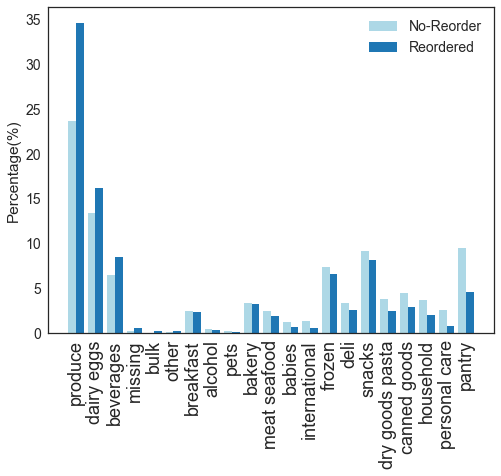

In [226]:
x=np.arange(len(dept_freq))
plt.figure(figsize=(8,6))
plt.bar(x, dept_freq['no_reorder']*100, width=0.4, label='No-Reorder', color='lightblue')
plt.bar(x+0.4, dept_freq['reordered']*100, width=0.4, label = 'Reordered', color='tab:blue')
plt.legend();
plt.ylabel('Percentage(%)')
plt.xticks(fontsize=18)
plt.xticks(x+0.2,dept.loc[dept_freq.index-1, 'department'], rotation=90);

In [89]:
aisle=pd.read_csv('data/aisles.csv')
df_p=pd.merge(df_p, aisle, on='aisle_id', how='left')


In [92]:
c = df_p.loc[df_p['reordered']==0,'aisle_id'].value_counts().sort_index()/\
df_p.loc[df_p['reordered']==0,'aisle_id'].count()
d = df_p.loc[df_p['reordered']==1,'aisle_id'].value_counts().sort_index()/\
df_p.loc[df_p['reordered']==1,'aisle_id'].count()


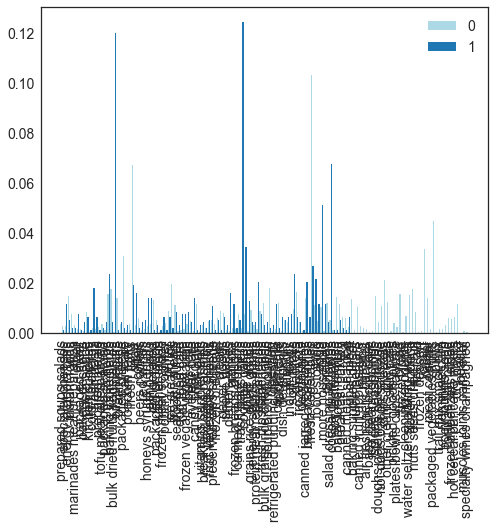

In [97]:
x1=np.arange(len(c))
x2=np.arange(len(d))
plt.figure(figsize=(8,6))
plt.bar(x1, c, width=0.4, label='0', color='lightblue')
plt.bar(x2+0.4, d, width=0.4, label = '1', color='tab:blue')
plt.legend();
plt.xticks(np.arange(0,len(c)),aisle.sort_values('aisle_id')['aisle'], rotation=90);

In [102]:
aisle_freq  = pd.DataFrame(c)
aisle_freq.columns=['no_reorder']
aisle_freq = pd.merge(aisle_freq, d.to_frame(), left_index=True, right_index=True, how='outer')

In [103]:
aisle_freq.fillna(0, inplace=True)

In [104]:
aisle_freq.rename(columns={'aisle_id':'reordered'}, inplace =True)
aisle_freq['diff'] = aisle_freq['reordered'] - aisle_freq['no_reorder']

In [106]:
aisle_freq.sort_values('diff', ascending=False, inplace=True)

In [107]:
aisle_freq.head()

,no_reorder,reordered,diff
24,0.067270,0.120172,0.052902
84,0.011248,0.034335,0.023086
123,0.044773,0.067597,0.022824
83,0.103220,0.124464,0.021243
120,0.033745,0.051502,0.017757


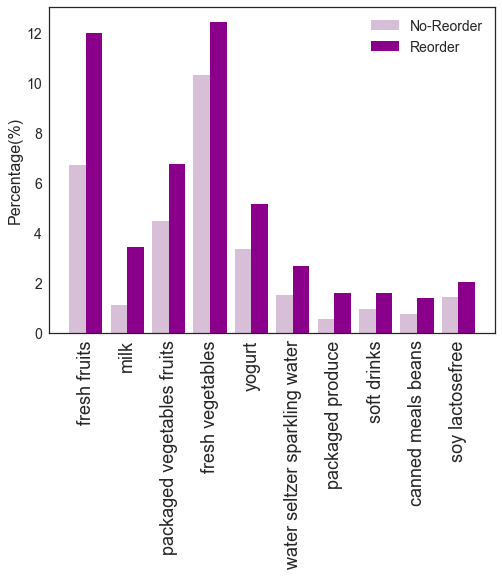

In [227]:
x=np.arange(10)
plt.figure(figsize=(8,6))
plt.bar(x, aisle_freq.iloc[0:10]['no_reorder']*100, width=0.4, label='No-Reorder', color='thistle')
plt.bar(x+0.4, aisle_freq.iloc[0:10]['reordered']*100, width=0.4, label = 'Reorder', color='darkmagenta')
plt.legend();
plt.xticks(fontsize=18)
plt.ylabel('Percentage(%)', fontsize=16)
plt.xticks(x+0.2,aisle.loc[aisle_freq.index[0:10]-1, 'aisle'], rotation=90, fontsize=18);

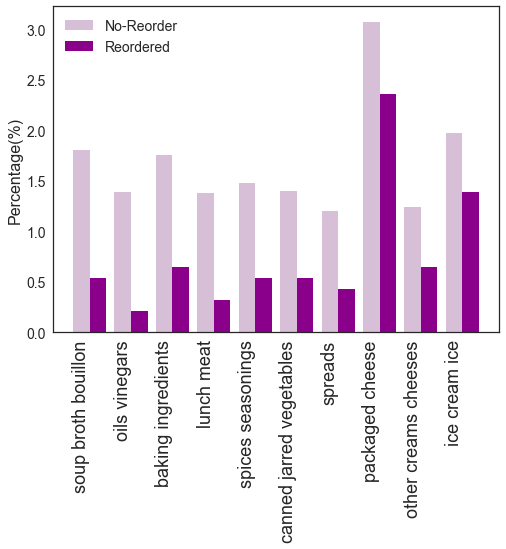

In [228]:
x=np.arange(10)
plt.figure(figsize=(8,6))
plt.bar(x, aisle_freq.iloc[-1:-11:-1]['no_reorder']*100, width=0.4, label='No-Reorder', color='thistle')
plt.bar(x+0.4, aisle_freq.iloc[-1:-11:-1]['reordered']*100, width=0.4, label = 'Reordered', color='darkmagenta')
plt.legend()
plt.ylabel('Percentage(%)', fontsize=16)
plt.xticks(x,aisle.loc[aisle_freq.index[-1:-11:-1]-1, 'aisle'], rotation=90,fontsize=18);